## Try phase association for stations on 10/14/2012
Refernce: https://github.com/yetinam/pyocto

In [4]:
# !pip3 install numpy
!pip3 install pyocto

  Could not find a version that satisfies the requirement pyocto (from versions: )
No matching distribution found for pyocto


In [3]:
import pyocto
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from scipy import signal
from obspy.signal.trigger import classic_sta_lta

from obspy.clients.fdsn import Client
from obspy.core.utcdatetime import UTCDateTime
from pnwstore.mseed import WaveformClient


ModuleNotFoundError: No module named 'pyocto'

In [105]:
# Import the velocity model from https://colab.research.google.com/github/yetinam/pyocto/blob/main/examples/02_velocity_models.ipynb#scrollTo=1c52ed9e-d9c1-4fa6-a549-de702bc9d439
# !wget https://github.com/yetinam/pyocto/raw/main/tests/data/graeber.csv

## Input Data

In [4]:
picks = pd.read_csv("~/notebooks/data/phase_association/20121014/picks_20121014.csv",index_col=0)
stations = pd.read_csv("~/notebooks/data/phase_association/20121014/stations_20121014.csv",index_col=0)

In [5]:
picks

,station,phase,time
0,FS09B,P,2012-10-14T00:05:57.814700Z
1,FS09B,P,2012-10-14T00:26:31.574700Z
2,FS09B,P,2012-10-14T00:37:17.174700Z
3,FS09B,P,2012-10-14T00:39:52.134700Z
4,FS09B,P,2012-10-14T00:47:23.734700Z
...,...,...,...
2067,M14B,S,2012-10-14T22:24:36.789869Z
2068,M14B,S,2012-10-14T22:26:19.909869Z
2069,M14B,S,2012-10-14T23:29:58.769869Z
2070,M14B,S,2012-10-14T23:32:10.929869Z


In [6]:
stations

,id,longitude,latitude,elevation
0,FS09B,-124.808502,40.438702,-2161.0
1,G10B,-125.553299,40.677898,-2936.0
2,G19B,-125.773598,41.307400,-3071.0
3,G25B,-124.586098,41.919899,-430.0
4,G27B,-126.016701,41.916599,-3480.0
5,J09B,-124.726997,43.151001,-252.0
6,M12B,-124.946098,42.183998,-1045.0
7,M14B,-124.589699,40.985001,-638.0


  ## Velocoty Models

In [7]:
velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=2.0,
)

In [8]:
?pyocto.OctoAssociator.from_area

## Create a 1D velocity model

In [85]:
# layers = pd.read_csv("graeber.csv")
# layers

In [86]:
# model_path = "velocity_model"
# pyocto.VelocityModel1D.create_model(layers, 1., 400, 250, model_path)

In [87]:
# velocity_model_1d = pyocto.VelocityModel1D(model_path, tolerance=2.0)

## The OctoAssociator class

In [9]:
associator = pyocto.OctoAssociator.from_area(
    lat=(40, 43.5),
    lon=(-126.5, -123),
    zlim=(0, 50),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=4,
    n_p_picks=3,
    n_s_picks=1,
    n_p_and_s_picks=1,
)

In [112]:
associator.crs

<Projected CRS: +proj=tmerc +lat_0=41.75 +lon_0=-124.75 +units=km  ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (kilometre)
- N[north]: Northing (kilometre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
associator.transform_stations(stations)
stations

,id,longitude,latitude,elevation,x,y,z
0,FS09B,-124.808502,40.438702,-2161.0,-4.963595,-145.625525,2.161
1,G10B,-125.553299,40.677898,-2936.0,-67.913996,-118.755232,2.936
2,G19B,-125.773598,41.307400,-3071.0,-85.719842,-48.651523,3.071
3,G25B,-124.586098,41.919899,-430.0,13.596424,18.883688,0.430
4,G27B,-126.016701,41.916599,-3480.0,-105.085006,19.280241,3.480
5,J09B,-124.726997,43.151001,-252.0,1.871087,155.626312,0.252
6,M12B,-124.946098,42.183998,-1045.0,-16.199984,48.223921,1.045
7,M14B,-124.589699,40.985001,-638.0,13.490014,-84.949193,0.638


## Convert the timestamps to floats

In [11]:
picks["time"] = picks["time"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ'))

In [12]:
picks["time"] = picks["time"].apply(lambda x: x.timestamp())
picks

,station,phase,time
0,FS09B,P,1.350173e+09
1,FS09B,P,1.350174e+09
2,FS09B,P,1.350175e+09
3,FS09B,P,1.350175e+09
4,FS09B,P,1.350176e+09
...,...,...,...
2067,M14B,S,1.350253e+09
2068,M14B,S,1.350254e+09
2069,M14B,S,1.350257e+09
2070,M14B,S,1.350258e+09


In [116]:
type(1.349050e+09)

float

## Delete unnecessary columns

In [117]:
# picks.drop(columns="Unnamed: 0", inplace=True)
# picks

In [118]:
# stations.drop(columns="Unnamed: 0", inplace=True)
# stations

## Apply  the associator

In [13]:
events, assignments = associator.associate(picks, stations)

In [14]:
events

,idx,time,x,y,z,picks
0,0,1.350178e+09,-99.823478,8.014299,24.609375,4
1,1,1.350182e+09,26.269336,-128.412984,40.234375,5
2,2,1.350184e+09,12.259024,-107.072404,49.609375,7
3,3,1.350197e+09,-18.096654,-97.926441,19.140625,4
4,4,1.350201e+09,-89.315744,-138.321111,36.328125,14
5,5,1.350216e+09,-18.096654,27.830552,1.171875,4
6,6,1.350226e+09,-75.305431,-127.650821,28.515625,4
7,7,1.350234e+09,-60.127592,-121.553512,37.890625,14
8,8,1.350239e+09,61.295118,-104.785913,8.984375,4
9,9,1.350244e+09,6.421393,-62.104752,1.171875,4


In [15]:
Counter(events['picks'])

Counter({4: 6, 14: 2, 5: 1, 7: 1})

In [2]:
associator.transform_events(events)
events["time"] = events["time"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)
events

NameError: name 'associator' is not defined

In [17]:
# events.to_csv('~/notebooks/src/association_events.csv')

In [1]:
assignments

NameError: name 'assignments' is not defined

In [19]:
all_pick_assignments = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))
all_pick_assignments.to_csv('~/notebooks/data/all_pick_assignments.csv')

,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick
0,0,2012-10-14 01:24:03.676530+00:00,-99.823478,8.014299,24.609375,4,41.815873,-125.951392,24.609375,0,283,-0.006772,G19B,P,1.350178e+09
1,0,2012-10-14 01:24:03.676530+00:00,-99.823478,8.014299,24.609375,4,41.815873,-125.951392,24.609375,0,843,0.125995,G27B,P,1.350178e+09
2,0,2012-10-14 01:24:03.676530+00:00,-99.823478,8.014299,24.609375,4,41.815873,-125.951392,24.609375,0,1053,-0.261009,M12B,P,1.350178e+09
3,0,2012-10-14 01:24:03.676530+00:00,-99.823478,8.014299,24.609375,4,41.815873,-125.951392,24.609375,0,1938,0.141786,M12B,S,1.350178e+09
4,1,2012-10-14 02:39:44.924554+00:00,26.269336,-128.412984,40.234375,5,40.593306,-124.439672,40.234375,1,12,0.377781,FS09B,P,1.350182e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,8,2012-10-14 18:16:43.973209+00:00,61.295118,-104.785913,8.984375,4,40.804200,-124.023617,8.984375,8,2047,-0.029840,M14B,S,1.350239e+09
60,9,2012-10-14 19:52:13.871130+00:00,6.421393,-62.104752,1.171875,4,41.190790,-124.673457,1.171875,9,163,1.220861,FS09B,P,1.350244e+09
61,9,2012-10-14 19:52:13.871130+00:00,6.421393,-62.104752,1.171875,4,41.190790,-124.673457,1.171875,9,1579,-0.811171,FS09B,S,1.350244e+09
62,9,2012-10-14 19:52:13.871130+00:00,6.421393,-62.104752,1.171875,4,41.190790,-124.673457,1.171875,9,257,-0.000484,G10B,P,1.350244e+09


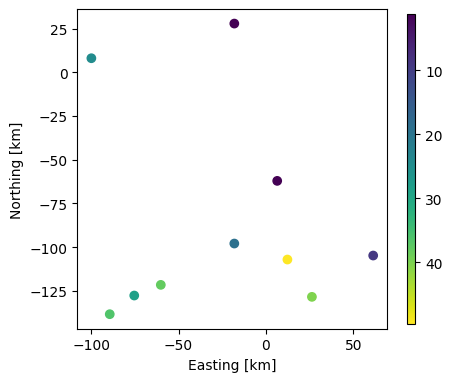

In [20]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

# ax.scatter(events["x"], events["y"], c=events["z"])
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["x"], events["y"], c=events["z"],cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()

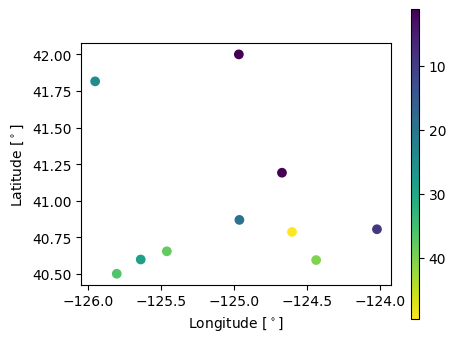

In [21]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

ax.set_xlabel("Longitude [$^\circ$]")
ax.set_ylabel("Latitude [$^\circ$]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["longitude"], events["latitude"], c=events["z"],cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()